# Music Royalties Strategy - End-to-End Backtest

This notebook demonstrates the complete workflow for the music royalties systematic trading strategy:
1. Data Loading & Preprocessing
2. Feature Engineering
3. Model Training & Validation
4. Portfolio Construction
5. Backtesting
6. Performance Evaluation

**Strategy Objective:** Systematically acquire Life of Rights (LOR) music royalty assets with high revenue stability and proven catalog age, targeting equity-like returns with low correlation to traditional markets.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Import strategy modules
import sys
sys.path.append('..')

from data_loader import load_and_prepare_data
from feature_engineering import engineer_all_features
from model_trainer import train_and_validate_model
from portfolio_constructor import PortfolioConstructor
from backtester import RoyaltyBacktester, prepare_universe_by_date
from performance_evaluator import evaluate_strategy_performance

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 1. Configuration

Load strategy configuration from `config.yaml`.

In [4]:
# Load configuration
config_path = Path('..') / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Strategy Configuration:")
print(f"  Target Return: {config['strategy']['target_annual_return']*100}%")
print(f"  Initial Capital: ${config['backtest']['initial_capital']:,}")
print(f"  Rebalancing: {config['portfolio']['rebalancing_frequency']}")
print(f"  Transaction Costs: {config['transaction_costs']['total_roundtrip_cost']*100}%")

Strategy Configuration:
  Target Return: 10.0%
  Initial Capital: $1,000,000
  Rebalancing: annual
  Transaction Costs: 11.0%


## 2. Data Loading & Preprocessing

Load music royalty transaction data. If no real data provided, synthetic data will be generated based on study findings.

In [5]:
# Load and split data
print("Loading data...")
data_splits = load_and_prepare_data(config, filepath=None)  # Use synthetic data

print(f"\n✓ Data loaded successfully")
print(f"  Train set:      {len(data_splits['train'])} transactions")
print(f"  Validation set: {len(data_splits['validation'])} transactions")
print(f"  Test set:       {len(data_splits['test'])} transactions")

# Preview training data
print("\nSample transactions:")
display(data_splits['train'][['asset_id', 'transaction_date', 'transaction_price', 
                               'revenue_ltm', 'revenue_lty', 'catalog_age', 
                               'contract_type', 'genre']].head())

INFO:data_loader:Generated 1000 synthetic transactions
INFO:data_loader:All required fields present
INFO:data_loader:Loaded 1000 transactions from 2017-01-02 00:00:00 to 2022-12-31 00:00:00
INFO:data_loader:Filtered to LOR contracts: 798 kept, 202 removed
INFO:data_loader:Removed 0 outliers with extreme stability ratios
INFO:data_loader:Data Summary: 798 transactions, $147,452,932 total volume
INFO:data_loader:Train: 394 | Validation: 139 | Test: 265


Loading data...

✓ Data loaded successfully
  Train set:      394 transactions
  Validation set: 139 transactions
  Test set:       265 transactions

Sample transactions:


,asset_id,transaction_date,transaction_price,revenue_ltm,revenue_lty,catalog_age,contract_type,genre
0,ASSET_0150,2017-01-02,146131.452859,13463.340675,15503.025900,59,LOR,Pop
1,ASSET_0723,2017-01-04,29926.508572,3292.375604,2634.061096,20,LOR,Rock
3,ASSET_0719,2017-01-06,66620.964473,6174.379929,5420.684774,17,LOR,Rock
5,ASSET_0757,2017-01-10,113662.884967,14860.205280,14724.729676,5,LOR,Rock
6,ASSET_0840,2017-01-11,6213.379968,1000.000000,1239.066915,2,LOR,Pop


### Data Distribution Analysis

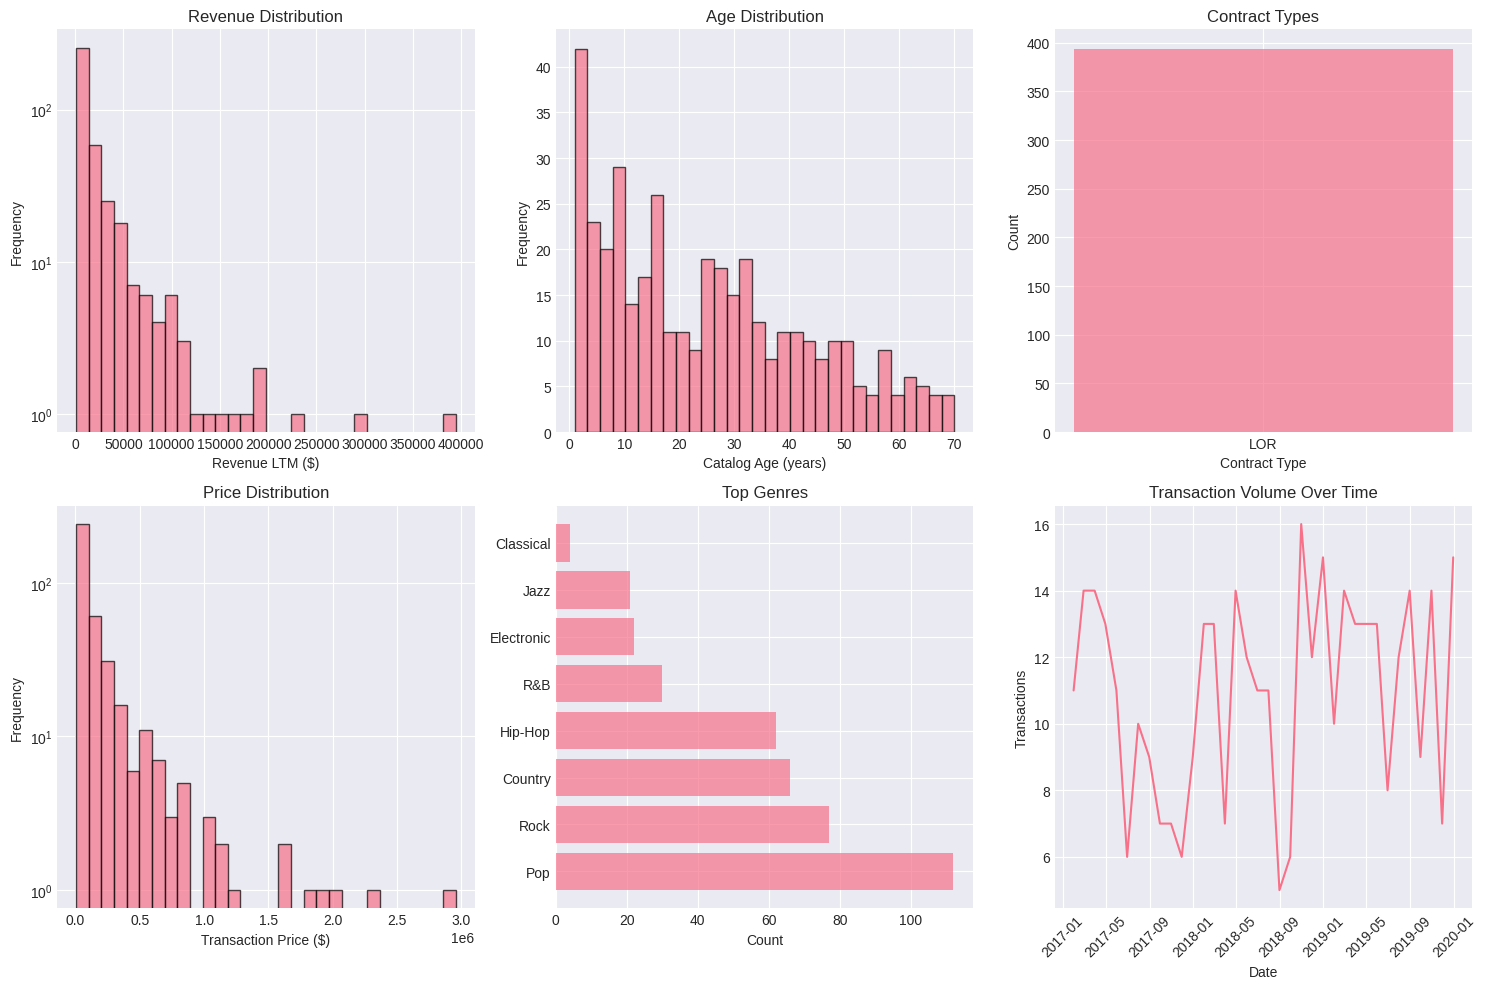

✓ Data distributions visualized


In [6]:
# Visualize data distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

train_data = data_splits['train']

# Revenue distribution
axes[0, 0].hist(train_data['revenue_ltm'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Revenue LTM ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Revenue Distribution')
axes[0, 0].set_yscale('log')

# Catalog age distribution
axes[0, 1].hist(train_data['catalog_age'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Catalog Age (years)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Age Distribution')

# Contract type
contract_counts = train_data['contract_type'].value_counts()
axes[0, 2].bar(contract_counts.index, contract_counts.values, alpha=0.7)
axes[0, 2].set_xlabel('Contract Type')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Contract Types')

# Transaction price distribution
axes[1, 0].hist(train_data['transaction_price'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Transaction Price ($)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Price Distribution')
axes[1, 0].set_yscale('log')

# Genre distribution
genre_counts = train_data['genre'].value_counts().head(8)
axes[1, 1].barh(genre_counts.index, genre_counts.values, alpha=0.7)
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_title('Top Genres')

# Transactions over time
monthly_counts = train_data.set_index('transaction_date').resample('M').size()
axes[1, 2].plot(monthly_counts.index, monthly_counts.values)
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Transactions')
axes[1, 2].set_title('Transaction Volume Over Time')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/data_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Data distributions visualized")

## 3. Feature Engineering

Calculate the two primary signals:
- **Stability Ratio** = Revenue_LTM / Revenue_LTY (target: ≈1.0)
- **Catalog Age** = Years since copyright (older = better)

In [ ]:
# Engineer features for all splits
print("Engineering features...")

train_df = engineer_all_features(data_splits['train'], config, include_interactions=False)
val_df = engineer_all_features(data_splits['validation'], config, include_interactions=False)
test_df = engineer_all_features(data_splits['test'], config, include_interactions=False)

print(f"\n✓ Feature engineering complete")
print(f"  Total features: {len(train_df.columns)}")
print(f"\nKey features:")
display(train_df[['asset_id', 'stability_ratio', 'catalog_age', 'price_multiplier', 
                   'stability_deviation', 'revenue_growth']].head())

### Feature Relationships

In [ ]:
# Visualize feature relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Stability ratio distribution
axes[0].hist(train_df['stability_ratio'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(1.0, color='red', linestyle='--', label='Target (1.0)')
axes[0].set_xlabel('Stability Ratio (LTM/LTY)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Stability Ratio Distribution')
axes[0].legend()

# Age vs Price Multiplier
axes[1].scatter(train_df['catalog_age'], train_df['price_multiplier'], alpha=0.5)
axes[1].set_xlabel('Catalog Age (years)')
axes[1].set_ylabel('Price Multiplier')
axes[1].set_title('Age Premium Effect')

# Stability vs Price Multiplier
axes[2].scatter(train_df['stability_ratio'], train_df['price_multiplier'], alpha=0.5)
axes[2].axvline(1.0, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Stability Ratio')
axes[2].set_ylabel('Price Multiplier')
axes[2].set_title('Stability Premium Effect')

plt.tight_layout()
plt.savefig('../results/feature_relationships.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature relationships visualized")

## 4. Model Training & Validation

Train linear regression model to predict fair price multipliers:

**Model:** PredictedMultiplier = β₀ + β₁(StabilityRatio) + β₂(CatalogAge) + ε

In [ ]:
# Train model
print("Training model...")
model, val_metrics = train_and_validate_model(train_df, val_df, config)

print(f"\n✓ Model training complete")
print(f"\nValidation Metrics:")
print(f"  MSE:  {val_metrics['mse']:.4f} (target: ≤{config['model']['target_mse']})")
print(f"  RMSE: {val_metrics['rmse']:.4f}")
print(f"  MAE:  {val_metrics['mae']:.4f}")
print(f"  R²:   {val_metrics['r2']:.4f}")

# Feature importance
importance = model.get_feature_importance()
print(f"\nFeature Importance:")
display(importance)

### Model Diagnostics

In [ ]:
# Model prediction vs actual
X_val = val_df[config['model']['features']]
y_val = val_df[config['model']['target']]
y_pred = model.predict(X_val)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Predicted vs Actual
axes[0].scatter(y_val, y_pred, alpha=0.5)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price Multiplier')
axes[0].set_ylabel('Predicted Price Multiplier')
axes[0].set_title(f'Model Predictions (R² = {val_metrics["r2"]:.3f})')
axes[0].legend()

# Residuals
residuals = y_val - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price Multiplier')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.savefig('../results/model_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Model diagnostics visualized")

## 5. Portfolio Construction

Calculate mispricing (predicted fair value - market price) and select top quintile (20%) most undervalued assets.

In [ ]:
# Calculate mispricing on test set
print("Calculating mispricing...")
test_df = model.calculate_mispricing(test_df)

print(f"\n✓ Mispricing calculated")
print(f"\nMispricing Statistics:")
print(f"  Mean:   {test_df['mispricing'].mean():.3f}")
print(f"  Median: {test_df['mispricing'].median():.3f}")
print(f"  Std:    {test_df['mispricing'].std():.3f}")
print(f"  Undervalued assets (mispricing > 0): {(test_df['mispricing'] > 0).sum()}")
print(f"  Overvalued assets (mispricing < 0):  {(test_df['mispricing'] < 0).sum()}")

# Show top undervalued assets
print("\nTop 10 Most Undervalued Assets:")
display(test_df.nlargest(10, 'mispricing')[['asset_id', 'predicted_multiplier', 
                                              'price_multiplier', 'mispricing', 
                                              'stability_ratio', 'catalog_age']])

## 6. Backtesting

Run full backtest with annual rebalancing.

In [ ]:
# Prepare universe by rebalancing dates
print("Preparing universe...")
universe_by_date = prepare_universe_by_date(test_df, config['portfolio']['rebalancing_frequency'])

print(f"  Rebalancing {len(universe_by_date)} times")

# Initialize backtester and portfolio constructor
backtester = RoyaltyBacktester(config)
constructor = PortfolioConstructor(config)

# Run backtest
print("\nRunning backtest...")
equity_curve = backtester.run_backtest(universe_by_date, model, constructor)

print(f"\n✓ Backtest complete")
print(f"  Initial capital: ${config['backtest']['initial_capital']:,}")
print(f"  Final value:     ${backtester.portfolio_value:,.0f}")
print(f"  Total return:    {(backtester.portfolio_value/config['backtest']['initial_capital'] - 1)*100:.2f}%")
print(f"  Total trades:    {len(backtester.trades)}")

### Equity Curve Visualization

In [ ]:
# Plot equity curve
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Equity curve
axes[0].plot(equity_curve['date'], equity_curve['portfolio_value'], 
             linewidth=2, label='Strategy')
axes[0].axhline(config['backtest']['initial_capital'], color='gray', 
                linestyle='--', label='Initial Capital')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].set_title('Strategy Equity Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drawdown
portfolio_values = equity_curve['portfolio_value']
running_max = portfolio_values.cummax()
drawdown = (portfolio_values - running_max) / running_max

axes[1].fill_between(equity_curve['date'], drawdown * 100, 0, 
                      alpha=0.7, color='red', label='Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_title('Strategy Drawdown')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/equity_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Equity curve visualized")

## 7. Performance Evaluation

Comprehensive performance metrics and statistical tests.

In [ ]:
# Get trades and evaluate performance
trades_df = backtester.get_trades_df()

print("Evaluating performance...")
performance = evaluate_strategy_performance(equity_curve, trades_df, config)

# Display key metrics
print("\n" + "="*80)
print("KEY PERFORMANCE METRICS")
print("="*80)

metrics = performance['metrics']
print(f"\nReturn Metrics:")
print(f"  Total Return: {metrics['total_return']*100:.2f}%")
print(f"  CAGR:         {metrics['cagr']*100:.2f}%")
print(f"  Volatility:   {metrics['annualized_volatility']*100:.2f}%")

print(f"\nRisk-Adjusted:")
print(f"  Sharpe Ratio:  {metrics['sharpe_ratio']:.3f}")
print(f"  Sortino Ratio: {metrics['sortino_ratio']:.3f}")
print(f"  Calmar Ratio:  {metrics['calmar_ratio']:.3f}")

print(f"\nDrawdown:")
print(f"  Max Drawdown: {metrics['max_drawdown']*100:.2f}%")

comparison = performance['benchmark_comparison']
print(f"\nBenchmark Comparison:")
print(f"  Beta:        {comparison['beta']:.3f}")
print(f"  Alpha:       {comparison['alpha']*100:.2f}%")
print(f"  Correlation: {comparison['correlation']:.3f}")

costs = performance['transaction_costs']
print(f"\nTransaction Costs:")
print(f"  Total Costs:  ${costs['total_costs']:,.0f}")
print(f"  Cost Ratio:   {costs['cost_ratio']*100:.2f}%")
print(f"  Total Trades: {costs['n_trades']}")

### Trade Analysis

In [ ]:
# Analyze trades
if len(trades_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Trade actions
    action_counts = trades_df['action'].value_counts()
    axes[0].bar(action_counts.index, action_counts.values, alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Trade Actions')
    
    # Transaction costs breakdown
    cost_components = {
        'Buyer Fees': trades_df['buyer_fee'].sum(),
        'Seller Commissions': trades_df['seller_commission'].sum(),
        'Slippage': trades_df['slippage'].sum()
    }
    axes[1].bar(cost_components.keys(), cost_components.values(), alpha=0.7)
    axes[1].set_ylabel('Total Cost ($)')
    axes[1].set_title('Transaction Cost Breakdown')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../results/trade_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Trade analysis visualized")
    print(f"\nTop 5 Most Expensive Trades:")
    display(trades_df.nlargest(5, 'total_cost')[['date', 'asset_id', 'action', 'total_cost']])

## 8. Save Results

Save equity curve, trades, and performance report.

In [ ]:
# Create results directory
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save equity curve
equity_path = results_dir / 'equity_curve.csv'
equity_curve.to_csv(equity_path, index=False)
print(f"✓ Saved equity curve to {equity_path}")

# Save trades
if len(trades_df) > 0:
    trades_path = results_dir / 'trades.csv'
    trades_df.to_csv(trades_path, index=False)
    print(f"✓ Saved trades to {trades_path}")

# Save performance report
report_path = results_dir / 'performance_report.txt'
with open(report_path, 'w') as f:
    f.write(performance['report'])
print(f"✓ Saved performance report to {report_path}")

print(f"\n{'='*80}")
print("END-TO-END BACKTEST COMPLETE")
print(f"{'='*80}")
print(f"\nFinal Results:")
print(f"  Total Return: {metrics['total_return']*100:.2f}%")
print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
print(f"  Max Drawdown: {metrics['max_drawdown']*100:.2f}%")
print(f"  Correlation:  {comparison['correlation']:.3f}")
print(f"\nAll results saved to: {results_dir}")